In [1]:
import pandas as pd
# xgboost
import xgboost as xgb
# metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
# kfold
from sklearn.model_selection import KFold
# gridsearch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# matplotlib
import matplotlib.pyplot as plt
# datetime
import datetime as dt
# numpy
import numpy as np
import sys
sys.path.insert(1, '../utils/')
from data_visualization import residuals_hist, residuals_scatter
from preprocessing import preprocess_cosumo 
import pickle
# catboosting
from catboost import CatBoostRegressor


In [2]:
# load train data
df = pd.read_csv('../data/consumo_material_clean_with_category.csv', parse_dates=['FECHAPEDIDO'])

# preprocess data
df = preprocess_cosumo(df)

# split train and test and filter by date
df_train = df[df['FECHAPEDIDO']<dt.datetime(year=2023,month=1,day=1)]
df_train = df_train[df_train['FECHAPEDIDO'] >= dt.datetime(year=2020,month=1,day=1)]
df_test = df[df['FECHAPEDIDO']>=dt.datetime(year=2023,month=1,day=1)]

In [5]:
df.head()

,FECHAPEDIDO,UNIDADESCONSUMOCONTENIDAS,PRECIO,STACKS_COMPRATS,CODIGO_B40558,CODIGO_B41691,CODIGO_C26183,CODIGO_C56207,CODIGO_E64488,CODIGO_E64543,...,CODIGO_F43331,CODIGO_F43580,CODIGO_F43581,CODIGO_F43585,CODIGO_F44200,CODIGO_F46843,CODIGO_F46846,CODIGO_F50071,TIPOCOMPRA_Compra menor,TIPOCOMPRA_Concurso
0,2023-01-01,10,62.590000,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2016-01-02,10,102.803729,4,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2016-01-02,5,12.100000,4,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,2016-01-02,50,215.325000,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2017-01-02,300,792.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
# drop columns
df_train.drop(columns=['FECHAPEDIDO'], inplace=True)
df_test.drop(columns=['FECHAPEDIDO'], inplace=True)

C:\Users\berna\AppData\Local\Temp\ipykernel_22912\545457921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['FECHAPEDIDO'], inplace=True)


In [22]:
# get X and y
X = df_train.drop(['STACKS_COMPRATS'], axis = 1)
y = df_train['STACKS_COMPRATS']

In [24]:
# gridsearch params for xgboost
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.8, 1.0],
    # 'colsample_bytree': [0.8, 0.9, 1.0],
    # 'gamma': [0, 0.1, 0.2],
    # 'min_child_weight': [1, 3, 5],
    'reg_alpha': [0.1, 0.2, 0.5],
    'reg_lambda': [0.1, 0.2, 0.5],
    # 'objective': ['reg:squarederror','reg:squaredlogerror','reg:linear']
}

In [32]:
X.head()

,UNIDADESCONSUMOCONTENIDAS,PRECIO,CODIGO_B40558,CODIGO_B41691,CODIGO_C26183,CODIGO_C56207,CODIGO_E64488,CODIGO_E64543,CODIGO_E64544,CODIGO_E64663,...,DEPARTMENT_94,DEPARTMENT_95,DEPARTMENT_96,DEPARTMENT_97,DEPARTMENT_98,DEPARTMENT_99,CATEGORY_B,CATEGORY_C,CATEGORY_E,CATEGORY_F
16,5,12.100000,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
17,5,12.100000,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
18,5,26.399925,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
19,300,27.588000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
20,300,49.302000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [26]:
# define the model
model = xgb.XGBRegressor(nthread=10, objective='reg:squarederror')

# define the KFold cross-validation object
folds = KFold(n_splits=10, shuffle=True, random_state=42)

# grid search the best parameters for the xgboost
grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=folds, n_jobs=10, verbose=1, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=No...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          nthread=10, num_parallel_tree=None,
                                          predictor=None, ...),
                   n_jobs=10,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 150, 200],
                                        'reg_alpha': [0.1, 0.2, 0.5],
                                        'reg_lambda': [0.1, 0.2, 0.5],
                                        'subsample': [0.5, 0.8, 1.0]},
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
grid_search.best_params_

In [28]:
# metrics for TRAIN
X_test = df_test.drop(['STACKS_COMPRATS'], axis = 1)
y_test = df_test['STACKS_COMPRATS'].reset_index(drop=True)
preds = grid_search.best_estimator_.predict(X)

mse = mean_squared_error(y, preds)
print('mse: ', mse)
mae = mean_absolute_error(y, preds)
print('mae: ', mae)
r2 = r2_score(y, preds)
print('r2: ', r2)


mse:  114.44347477888056
mae:  3.9534401339302345
r2:  0.9033473180538303


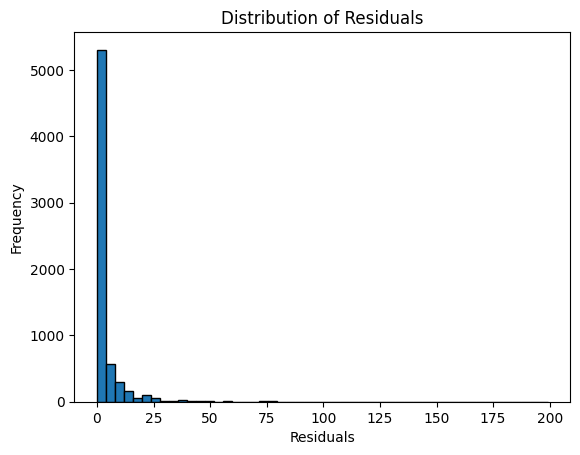

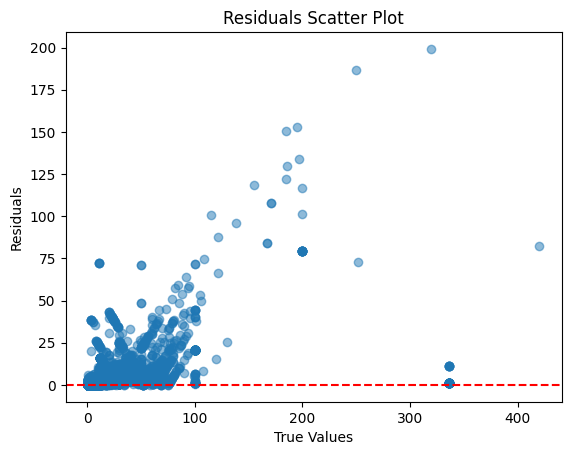

Series([], Name: STACKS_COMPRATS, dtype: float64)
212     507
356     550
965     873
2255    523
Name: STACKS_COMPRATS, dtype: int64


In [29]:
# graphics of the results
residuals = np.abs(preds-y)


# Create a histogram of residuals
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Alternatively, create a scatter plot
plt.scatter(y, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.title('Residuals Scatter Plot')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()

# show the worst residuals
print(residuals[residuals>400])
print(y_test[y_test>450])




In [30]:
# metrics for TEST
X_test = df_test.drop(['STACKS_COMPRATS'], axis = 1)
y_test = df_test['STACKS_COMPRATS'].reset_index(drop=True)
preds = grid_search.best_estimator_.predict(X_test)

mse = mean_squared_error(y_test, preds)
print('mse: ', mse)
mae = mean_absolute_error(y_test, preds)
print('mae: ', mae)
r2 = r2_score(y_test, preds)
print('r2: ', r2)


mse:  1195.1622451479263
mae:  9.857216720897545
r2:  0.5200727718007909


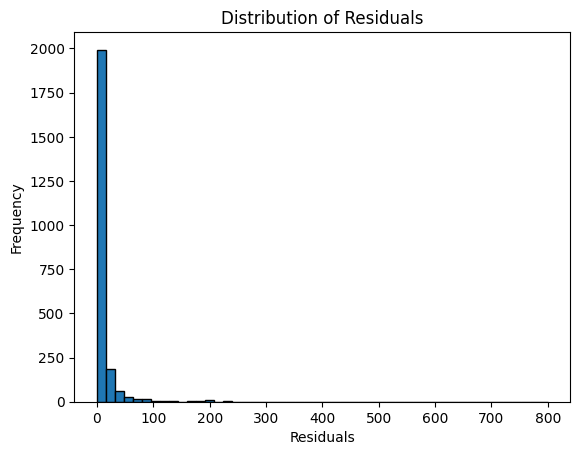

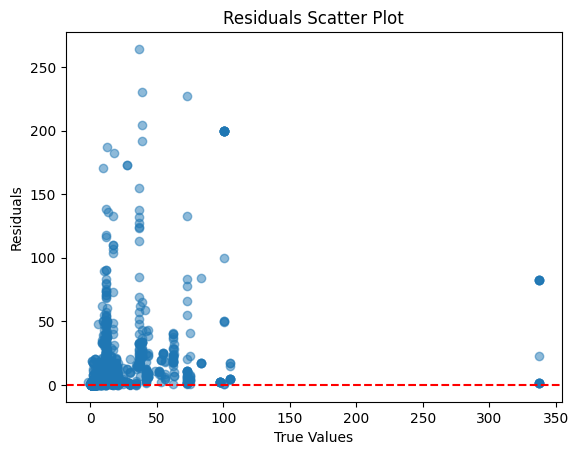

212     434.122307
356     477.122307
965     800.122307
2255    450.122307
Name: STACKS_COMPRATS, dtype: float64
212     507
356     550
965     873
2255    523
Name: STACKS_COMPRATS, dtype: int64


In [31]:
# graphics of the results
residuals = np.abs(preds-y_test)
residuals_hist(y_test, preds)
residuals_scatter(y_test[residuals<400], preds[residuals<400])

# show the worst residuals
print(residuals[residuals>400])
print(y_test[y_test>450])


